## Fake News or Not?
#### Ford St. John and Matthew Duc Nguyen
<img src="https://static01.nyt.com/images/2019/10/02/business/02TRUMPMEDIA-01/02TRUMPMEDIA-01-superJumbo.jpg" height=500 width=750>

Using the Kaggle dataset [Fake News](https://www.kaggle.com/c/fake-news/data) we will attempt to train a machine learning model that can identify news articles as "reliable" or "unreliable" (e.g. fake) based on the following article attributes
1. id: a unique ID to identify the article
2. title: the title of the news article
3. author: the author of the news article
4. text: the content (actual text) of the news article; may or may not be incomplete

Articles are labeled with a boolean 1|0 indicator with 1 = "unreliable" and 0 = "reliable"

## Step 1: Exploratory data analysis
Before undertaking any model training, we want to get a feel for the data and identify features that we think might merit further exploration.  Our dataset has been pre-split for us into a training and testing set.  We'll use the training dataset to train our model, and use the testing dataset to test our model on data it's never seen before

In [1]:
# Ensure the kaggle.json credentials are located in the correct directory.  This is needed to run the kaggle API
import os
import shutil
import stat
if '.kaggle' not in os.listdir('.'):
    os.makedirs(os.path.join(os.getcwd(), '.kaggle'))
kaggle_dir = os.path.join(os.getcwd(), '.kaggle')
kaggle_json = os.path.join(os.getcwd(), 'kaggle.json')
kaggle_path = os.path.join(kaggle_dir, 'kaggle.json')
if not os.path.isfile(kaggle_path):
    shutil.copyfile(kaggle_json, kaggle_path)
os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), stat.S_IRWXU)

In [2]:
# Imports needed to acquire and hold our data
import pandas as pd
import kaggle

# Import the data using the kaggle API
!kaggle competitions download -c fake-news

# Unzip the data and read it in as a Pandas DataFrame
from zipfile import ZipFile
with ZipFile('fake-news.zip', 'r') as zipobj:
    zipobj.extractall()
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('submit.csv')

# Join the test and submit datasets together.  Submit contains the "true" classification for the articles present in the test dataset
test = pd.merge(test, submit)

fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)


With our data loaded, we can now begin to explore our data.  We'll start by simply looking at the head of both datasets.  We'll then look at the relative number of "fake" news articles to reliable news articles and compare those rates in our training and testing datasets

In [3]:
# Let's look at the first few records of our data 
print("******** Training dataset *************")
print(train.head(5))
print("****************************************")
print()
print("********* Testing dataset **************")
print(test.head(5))
print("*****************************************")

******** Training dataset *************
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  
****************************************

********* Testing dataset **************
      id                

Text(0, 0.5, 'Count')

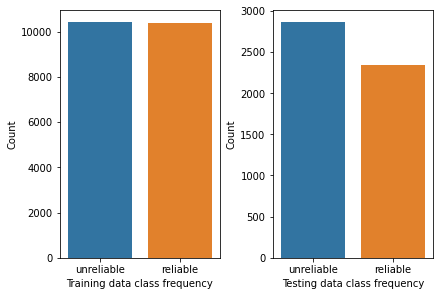

In [4]:
# Let's look at the relative rates of fake news to reliable news
# Import visualization packages
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Prepare training set data
train_counts = train['label'].value_counts()
train_counts.rename({0: 'reliable', 1: 'unreliable'}, inplace=True)
# Prepare testing set data
test_counts = test['label'].value_counts()
test_counts.rename({0: 'reliable', 1: 'unreliable'}, inplace=True)

# Plot it
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
#fig.tight_layout()
sns.barplot(x=train_counts.index, y=train_counts, ax=ax1)
ax1.set_xlabel('Training data class frequency')
ax1.set_ylabel('Count')
sns.barplot(x=test_counts.index, y=test_counts, ax=ax2)
ax2.set_xlabel('Testing data class frequency')
ax2.set_ylabel('Count')

So it looks like it's a 50:50 split between "fake" articles and reliable articles in our training dataset, and > 50% of the articles in our test dataset are labeled as fake (unreliable).  The distributions are relatively similar between the two datasets, so we won't worry too much that there's a variance.  Next, let's check and see if any of our records contain missing values.

In [5]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

There are 558 records missing a title, 1957 records missing the author and 39 records missing any article content at all.  We likely want to drop records that don't contain any article content.  How can an article be fake news or not if it doesn't contain any content?  Let's quickly look at the data records that are listed as missing "text"

In [6]:
missing_text = train[train.text.isna()]
missing_text

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1


Makes sense - an article that doesn't have any text is "unreliable".  But this isn't really interesting for prediction purposes, so let's remove these records that have missing article content from our training and testing sets

In [7]:
train = train[train.text.notna()]
test = test[test.text.notna()]

Articles that are missing the author or title are probably pretty suspect, let's see if we can confirm that with a confusion matrix

In [8]:
pd.crosstab(train.author.isna(), train.label, rownames=['Missing Author'], normalize='index')

label,0,1
Missing Author,,
False,0.549859,0.450141
True,0.013556,0.986444


In [9]:
pd.crosstab(train.title.isna(), train.label, rownames=['Missing Title'], normalize='index')

label,0,1
Missing Title,,
False,0.514132,0.485868
True,0.000000,1.000000


Although not surprising, we probably want to throw these records out too.  Every article that's missing a title was labeled as "unreliable" in our training dataset.  Not very interesting for classification, so we likely want to remove these from the problem space.  Similarly, 98.6% of the articles that are missing an author are also labeled as unreliable. For posterity, let's review the articles that are missing an author, but **are not** labeled as unreliable, to try and see if we can glean any insight into why these were labeled the way they were

In [10]:
missing_author_not_fake = train[(train.author.isna()) & (train.label == 0)]
missing_author_not_fake

,id,title,author,text,label
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
685,685,The New York Times to Offer Open Access on Web...,NaN,The New York Times is inviting readers to take...,0
2785,2785,How the Poll Was Conducted - The New York Times,NaN,The latest New York News Poll is based on te...,0
3203,3203,37 Who Saw Murder Didn’t Call the Police - The...,NaN,"For more than half an hour 38 respectable, law...",0
3470,3470,"‘My First Gay Bar’: Rachel Maddow, Andy Cohen ...",NaN,"For generations of gays and lesbians, especial...",0
3675,3675,"2 TV Shows, 4 Books and 7 Viral Videos for You...",NaN,Summer’s almost over. Here’s a cultural diet f...,0
5239,5239,Text of F.B.I. Director’s Remarks on Investiga...,NaN,Following is the prepared text of remarks by D...,0
5608,5608,"As Hurricane Matthew Nears U.S., Residents Get...",NaN,"• Hurricane Matthew, a deadly storm with maxim...",0
5911,5911,Keep Your Family Close and Your Roomba Closer ...,NaN,How lovable can a robot be? A study of Roomba ...,0
7032,7032,Reactions to the Supreme Court Ruling on Texas...,NaN,"In a major abortion ruling Monday, the Supreme...",0


Let's inspect one of these records in detail to see if we can glean why the article is suspicious or not

In [11]:
train.iloc[8].title
train.iloc[8].text

'Donald J. Trump is scheduled to make a highly anticipated visit to an   church in Detroit on Saturday, the first such visit of his campaign. There, he will participate in a    session conducted by Bishop Wayne T. Jackson of the church, Great Faith Ministries International. Given the importance of the visit, the Trump team went so far as to script Mr. Trump’s answers to Bishop Jackson’s questions, which were submitted in advance. After this article was published on Thursday night, a campaign official said that Mr. Trump would also speak to the church’s congregation and then tour some neighborhoods with Ben Carson, a former presidential candidate and Detroit native. Below are excerpts from a draft of the script that was obtained by The New York Times. _____ Mr. Trump there is racial divide in our country and it is evident that the tension is boiling over. Case and point Reverend Pinckney in South Carolina was gunned down when a white young man came into their Bible Study and slaughtered

The title informs that this article came from the New York Times, a very reputable news source.  Even though the author is missing, perhaps the fact that this is a New York Times article negates any reliability issues we might infer from the missing author.  For now we'll leave in records that are missing their authors, although our ML models will likely always classify articles missing an author as unreliable (as the misclassification error will be very minimal if we classify the few articles **without** authors as unreliable, even though they were labeled as reliable).  We'll throw out the records that are missing a title, as all of those were considered unreliable

In [12]:
train = train[train.title.notna()]
test = test[test.title.notna()]

Before completing our EDA, let's review some really basic statistics about titles, authors, and text as they relate to reliable or unreliable news sources.  For authors and titles, let's see if the length of the title or the number of authors is at all related to the reliability of the article.  For the text content, let's see if the number of words has any impact

In [13]:
# Import the nltk (Natural Language Toolkit) library to perform word and sentence processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
import string

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Cast the title, author and text to str types
train[['title','author','text']] = train[['title','author','text']].astype('string')

# Compute the length of the title
train['title-length'] = train['title'].apply(lambda x: len(str(x)))

# Get the number of words in the title and the main article text.  Note it takes a while for the tokenization
stoplist = set(stopwords.words('english') + list(string.punctuation)) # Sets have O(1) lookup in Python
def count_words(s):
    return len([word for word in word_tokenize(s) if word.lower() not in stoplist and not word.isdigit()])

train['title-word-count'] = train['title'].apply(count_words)
# Note that nltk.word_tokenize is relatively slow on large text entries.  We'll use a simpler function for the number of words in the article "text" field (though not as accurate)
train['text-word-count'] = train['text'].apply(lambda x: len(str(x).split()))

"""
Get the number of authors from the author field by searching for proper nouns
The function we use is an amended version of this code here: https://tim.mcnamara.nz/post/2650550090/extracting-names-with-6-lines-of-python-code
"""
def get_people(text):
    people = []
    for sentence in sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sentence))):
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    people.append(' '.join(c[0] for c in chunk.leaves()))
    return people
train['author-count'] = train['author'].apply(lambda x: len(get_people(x)) if pd.notnull(x) else 0)

Text(0.5, 1.0, '# Authors in reliable news articles')

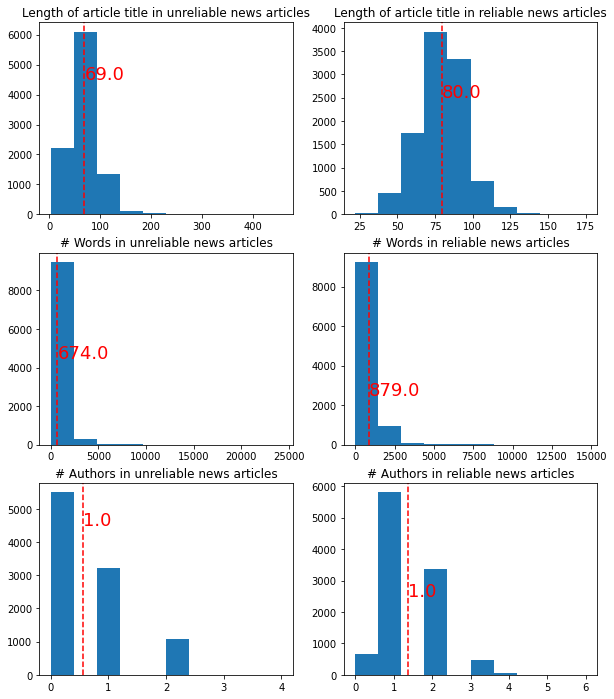

In [15]:
# We'll create plots of these values showing the frequency of unreliable articles as it relates to the counts
fix, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=2, figsize=(10,12))
# Length of the article title
train_title_length = train[train.label == 1]['title-length']
ax1[0].hist(train_title_length)
ax1[0].axvline(train_title_length.mean(), linestyle='dashed', color='red')
ax1[0].text(train_title_length.mean(), 4500, str(round(train_title_length.mean(), 0)), color='red', fontsize=18)
ax1[0].set_title('Length of article title in unreliable news articles')
train_title_length = train[train.label == 0]['title-length']
ax1[1].hist(train_title_length)
ax1[1].axvline(train_title_length.mean(), linestyle='dashed', color='red')
ax1[1].text(train_title_length.mean(), 2500, str(round(train_title_length.mean(), 0)), color='red', fontsize=18)
ax1[1].set_title('Length of article title in reliable news articles')

# Number of words in the article
train_text_words = train[train.label == 1]['text-word-count']
ax2[0].hist(train_text_words)
ax2[0].axvline(train_text_words.mean(), linestyle='dashed', color='red')
ax2[0].text(train_text_words.mean(), 4500, str(round(train_text_words.mean(), 0)), color='red', fontsize=18)
ax2[0].set_title('# Words in unreliable news articles')
train_text_words = train[train.label == 0]['text-word-count']
ax2[1].hist(train_text_words)
ax2[1].axvline(train_text_words.mean(), linestyle='dashed', color='red')
ax2[1].text(train_text_words.mean(), 2500, str(round(train_text_words.mean(), 0)), color='red', fontsize=18)
ax2[1].set_title('# Words in reliable news articles')

# Number of authors
train_authors = train[train.label == 1]['author-count']
ax3[0].hist(train_authors)
ax3[0].axvline(train_authors.mean(), linestyle='dashed', color='red')
ax3[0].text(train_authors.mean(), 4500, str(round(train_authors.mean(), 0)), color='red', fontsize=18)
ax3[0].set_title('# Authors in unreliable news articles')
train_authors = train[train.label == 0]['author-count']
ax3[1].hist(train_authors)
ax3[1].axvline(train_authors.mean(), linestyle='dashed', color='red')
ax3[1].text(train_authors.mean(), 2500, str(round(train_authors.mean(), 0)), color='red', fontsize=18)
ax3[1].set_title('# Authors in reliable news articles')

## Step 2: Text Processing
In order to use our text fields for model building, we need to process the text data within each field to transform it into a format suitable for modeling.  This generally involves the following steps:

1. Simple cleansing
    1. Remove punctuation, special characters, URLs, etc.
    2. Remove leading, trailing and extra white space/tabs
    3. Correct typos, slang, and convert abbreviated words into their "normal" form
2. Stop word removal - remove generic stop words from the text fiel such as "I", "you", "a", "the", etc.  These don't add much meaning to the actual content of the text
3. Word vectorization - machine learning models typically need numerical data.  Word vectorization is the process of converting raw text into a vector of numerical data
    1. We can use sklearn BoW (Bag of Words) and compute the following:
        1. Count vector - builds a list of all words from a corpus of documents (e.g. list of documents) and counts how many the words appear in each document
        2. TF-IDF (Term Frequency Inverse Document Frequencies) - The "value" of words increases proportionally to the count of that word in the document, but is inversely propotional to the frequency of the word in the corpus
    2. Word2Vec - another NLP library, uses a neural net to learn word associations from a corpus of text. The neural net can detect synonomous words or suggest additional words for partial sentences.  This library builds word vectors much like BoW does 

In [16]:
"""
Below are the methods we'll use to first cleanse the text data in our title and text (e.g. article) fields.
The "author" field we'll perform more custom processing
"""
import re

# Below we're going to try and use Pandas vectorized methods to make processing as quick as possible
cachedstopwords = stopwords.words('english')
def simple_cleanse(df, column_name):
    # Convert to lowercase
    df[column_name+'_clean'] = df[column_name].str.lower()
    # Strip leading and trailing whitespace
    df[column_name+'_clean'] = df[column_name+'_clean'].str.strip()
    #Remove all punctuation
    df[column_name+'_clean'] = df[column_name+'_clean'].str.translate(str.maketrans('','',string.punctuation))
    # Remove stopwords
    df[column_name+'_clean'] = df[column_name+'_clean'].apply(lambda text: ' '.join([word for word in text.split() if word not in cachedstopwords]))
    # Remove numbers
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'[0-9]+','', regex=True)
    # Remove URLs (anything that begins with HTTP)
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'http\S+','', regex=True)
    # Remove redundant whitespace
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'\s+', ' ', regex=True)
    # Remove apostrophes - these aren't really relevant for word analysis
    df[column_name+'_clean'] = df[column_name+'_clean'].str.replace(r'(\'|\"|\`|\’)', "", regex=True)
        
simple_cleanse(train, 'text')
simple_cleanse(train, 'title')

# Let's also tokenize our "cleaned" words for more processing
train['text_clean_tok'] = train['text_clean'].apply(word_tokenize)
train['title_clean_tok'] = train['title_clean'].apply(word_tokenize)

In [18]:
"""
Here we use sci-kit learn to vectorize our cleansed text
"""
# First we build a vector of word counts
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer = CountVectorizer()
text_counts = countvectorizer.fit_transform(train.text_clean)
title_counts = countvectorizer.fit_transform(train.title_clean)

# TF-IDF conversion from the count vector
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
text_tfidf = tfidf.fit_transform(text_counts)
title_tfidf = tfidf.fit_transform(title_counts)

In [19]:
"""
Additional features
    Here we'll add some other features which might be of interest.  For example, does the article text contain mispelled words?  If so how many?
"""
from spellchecker import SpellChecker
spell = SpellChecker()
train['title_mispelled'] = train['title_clean_tok'].apply(lambda x: len(spell.unknown(x)))
train['text_mispelled'] = train['text_clean_tok'].apply(lambda x: len(spell.unknown(x)))

In [20]:
# Before we begin builidng models, we're going to free some memory
del globals()['missing_author_not_fake']
del globals()['train_authors']
del globals()['train_text_words']
del globals()['train_title_length']
del globals()['missing_text']
del globals()['stoplist']
import gc
gc.collect()

## Step 3: Building ML Algorithms
In this section we'll use our vectorized text data with some of our other features to try and classify articles as real or fake. There are a number of ML models that one can utilize for classification, but we're going to consider a subset of the model space for this exercise
1. Naive Bayes - this is usually a good baseline to compare other algorithms against.  Basically we just apply Bayes' theorem with the naive assumption of conditional independence between every pair of features
2. Logistic Regression - logistic regression models are very interpretable, in that the coefficient value computed on a feature states its' relation to the predicted probability for a class value (in terms of log odds).  For example, a positive coefficient on the "number of mispelled words in the article" features can be interpreted as the more mispelled words found in the article, the more likely the article is to be fake
3. Gradient Boosting - this is the ML algorithm we'll focus on in this project.  Gradient boosting has a lot of coverage in the literature, and is known to provide very powerful predictors.  The drawback is that gradient boosting tends to overfit the data.  In this project we benefit from the presence of a test set that we can provide in addition to our training dataset.  When building the gradient boost model, the algorithm will penalize features that overfit on the train dataset but underfit (or provide poor prediction) on the test dataset

In [21]:
# Testing set preparation
# Before we build our models, let's prepare our test dataset with the same features as we've prepared in our training dataset

# Compute the author count
test['author-count'] = test['author'].apply(lambda x: len(get_people(x)) if pd.notnull(x) else 0)

# Cleanse the title and article text fields
simple_cleanse(test, 'text')
simple_cleanse(test, 'title')

# Tokenize the words in the cleaned fields
test['text_clean_tok'] = test['text_clean'].apply(word_tokenize)
test['title_clean_tok'] = test['title_clean'].apply(word_tokenize)

# Compute the count of mispelled words
test['title_mispelled'] = test['title_clean_tok'].apply(lambda x: len(spell.unknown(x)))
test['text_mispelled'] = test['text_clean_tok'].apply(lambda x: len(spell.unknown(x)))

# Vectorize the title and article text fields
text_counts = countvectorizer.fit_transform(test.text_clean)
title_counts = countvectorizer.fit_transform(test.title_clean)
text_tfidf_test = tfidf.fit_transform(text_counts)
title_tfidf_test = tfidf.fit_transform(title_counts)

In [30]:
# Remove redundant columns in the dataset to reduce the memory footprint
train.drop(columns=['title','text','author','text_clean','title_clean'], inplace=True)
test.drop(columns=['title','text','author','text_clean','title_clean'], inplace=True)
gc.collect()

Index                 161624
id                    161624
label                 161624
title-length          161624
title-word-count      161624
text-word-count       161624
author-count          161624
text_clean_tok      80553272
title_clean_tok      2970192
title_mispelled       161624
text_mispelled        161624
dtype: int64
Index                 40568
id                    40568
title                859043
author               349782
text               47994532
label                 40568
author-count          40568
text_clean         33405147
title_clean          666175
text_clean_tok     20495080
title_clean_tok      741872
title_mispelled       40568
text_mispelled        40568
dtype: int64
